<a href="https://colab.research.google.com/github/MaximusDonald/medipass/blob/main/ActiveLearningEnglish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Active Learning Core Concepts

**Active Learning vs. Passive Learning:**

**Execute the following notebook cells**:

-   look at the 2D PCA visualization of the [Forest
    Covertype](https://archive.ics.uci.edu/dataset/31/covertype) dataset
    (`sklearn.datasets.fetch_covtype`),
-   read the description of the dataset
    (<https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset>),
-   consider what the performance gap tells us about the opportunity of
    active learning for this dataset.

In [ ]:
import numpy as np
from sklearn.conftest import fetch_covtype
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


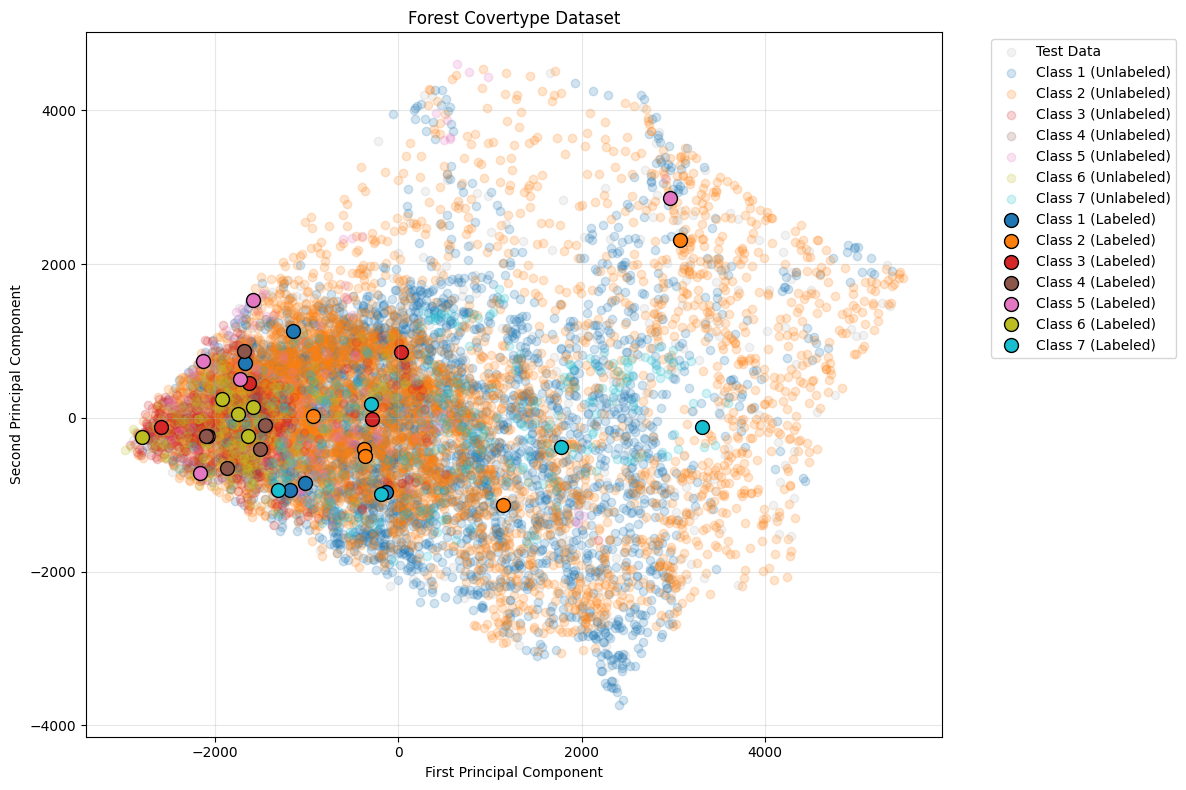

Total samples: 11000
Training samples: 10000
Test samples: 1000
Initially labeled samples: 35
Unlabeled pool size: 9965


In [ ]:



def create_al_synthetic_dataset(
    n_samples=10000,
    noise=0.3,
    random_state=42,
    n_samples_test=1000,
):
    # Load the Forest Covertype dataset
    X, y = fetch_covtype(return_X_y=True)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=n_samples,
        test_size=n_samples_test,
        random_state=random_state,
        stratify=y
    )

    # Select initial labeled points (5 from each class)
    train_idx = np.arange(len(y_train))
    class_indices = [train_idx[y_train == c] for c in np.unique(y_train)]

    np.random.seed(random_state + 3)
    labeled_idx = np.concatenate([
        np.random.choice(class_idx, 5, replace=False)
        for class_idx in class_indices
    ])
    unlabeled_idx = np.setdiff1d(train_idx, labeled_idx)

    return X_train, y_train, X_test, y_test, labeled_idx, unlabeled_idx


def visualize_dataset(
    X_train, y_train, labeled_idx, X_test=None, y_test=None, title="Forest Covertype Dataset"
):
    plt.figure(figsize=(12, 8))

    # Use PCA to reduce dimensionality for visualization
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)

    if X_test is not None:
        X_test_2d = pca.transform(X_test)
        # Plot test points if provided
        plt.scatter(
            X_test_2d[:, 0],
            X_test_2d[:, 1],
            c="gray",
            label="Test Data",
            alpha=0.1,
            zorder=-10,
        )

    # Get unique classes
    classes = np.unique(y_train)
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    # Plot unlabeled training points
    for i, (c, color) in enumerate(zip(classes, colors)):
        mask = y_train == c
        plt.scatter(
            X_train_2d[mask][:, 0],
            X_train_2d[mask][:, 1],
            c=[color],
            label=f"Class {c} (Unlabeled)",
            alpha=0.2,
        )

    # Highlight labeled points
    for i, (c, color) in enumerate(zip(classes, colors)):
        mask = y_train[labeled_idx] == c
        if np.any(mask):
            plt.scatter(
                X_train_2d[labeled_idx][mask][:, 0],
                X_train_2d[labeled_idx][mask][:, 1],
                c=[color],
                label=f"Class {c} (Labeled)",
                s=100,
                edgecolor="black",
            )

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


# Create and visualize the dataset
X_train, y_train, X_test, y_test, labeled_idx, unlabeled_idx = (
    create_al_synthetic_dataset()
)
visualize_dataset(X_train, y_train, labeled_idx, X_test, y_test)
plt.show()

# Print some statistics
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Initially labeled samples: {len(labeled_idx)}")
print(f"Unlabeled pool size: {len(unlabeled_idx)}")

In [ ]:
np.unique(y_train)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

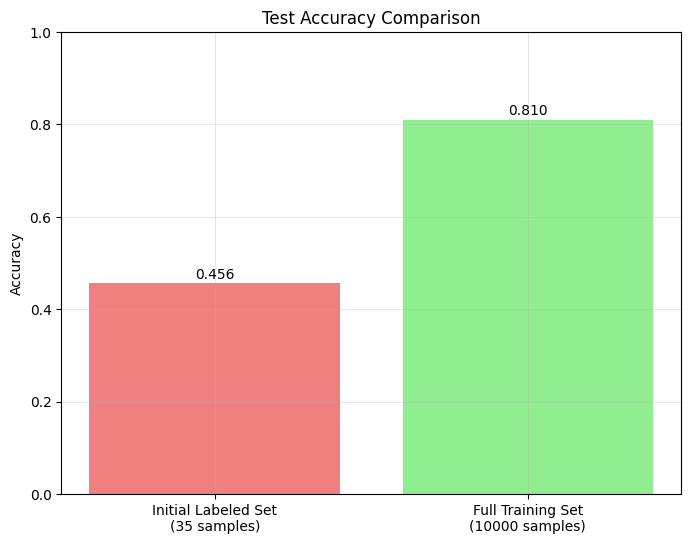

Performance gap: 0.354


In [ ]:
def create_classifier(seed=42):
    return RandomForestClassifier(random_state=seed)


initial_classifier = create_classifier()
initial_classifier.fit(X_train[labeled_idx], y_train[labeled_idx])
initial_acc = accuracy_score(y_test, initial_classifier.predict(X_test))

full_classifier = create_classifier()
full_classifier.fit(X_train, y_train)
full_acc = accuracy_score(y_test, full_classifier.predict(X_test))

# Plot results
plt.figure(figsize=(8, 6))
accuracies = [initial_acc, full_acc]
plt.bar(
    [f"Initial Labeled Set\n({len(labeled_idx)} samples)", f"Full Training Set\n({len(y_train)} samples)"],
    accuracies,
    color=["lightcoral", "lightgreen"],
)
plt.ylim(0, 1)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha="center")

plt.show()

print(f"Performance gap: {full_acc - initial_acc:.3f}")

Whenever there is such a performance gap, Active Learning can be your good ally to reach the same performance quickly like on the Full Training Set. It does not means you can not achieve the same thing just by training on the whole training set but you waste compute and time.

**Implement a pool-based active learning loop for this AL dataset**

Query the pool set one by one for up to 750 queries using the
following query strategies, which we have discussed in the lecture:

1.  **Uncertainty Sampling**

    -   Least Confident: selects examples with lowest maximum predicted
        probability
    -   Margin Sampling: uses difference between top two predicted
        probabilities
    -   Entropy Sampling: uses information-theoretic entropy across all
        class probabilities

2.  **Query-by-Committee (QBC)**

    -   Vote Entropy: measures disagreement among ensemble members using
        each members class prediction.

3.  **Random Sampling** (baseline)

    -   Used as a comparison benchmark
    -   Randomly selects examples from the unlabeled pool


> **Note**
>
> For Query-by-Committee, train a bootstrapped ensemble of 3 random
> forest classifiers by creating bootstrap samples from the training
> set.


# Some usefull function

In [ ]:
def train(model,
          n_iterations,
          labeled_idx,
          unlabeled_idx,
          score_fn):
    # Dictionaries to store training and test accuracy over iterations
    acc_train_list = {}
    acc_test_list = {}

    for i in range(1, n_iterations+1):
        # Train the model on the current labeled dataset
        model.fit(X_train[labeled_idx], y_train[labeled_idx])

        # Select the next sample from the unlabeled pool using the scoring function
        pool_index = score_fn(model, X_train[unlabeled_idx])

        # Evaluate accuracy on full training and test sets
        acc_train = model.score(X_train, y_train)
        acc_test = model.score(X_test, y_test)

        # Record accuracy keyed by the number of labeled samples
        acc_train_list[len(labeled_idx)] = acc_train
        acc_test_list[len(labeled_idx)] = acc_test

        # Update labeled and unlabeled sets
        labeled_idx = np.append(labeled_idx, pool_index)
        unlabeled_idx = np.delete(unlabeled_idx, pool_index)

        # Print progress every 10 iterations
        if i % 10 == 0:
            print(f"Iteration: {i}/{n_iterations}")

    return acc_train_list, acc_test_list


In [ ]:
def plot(acc_train, acc_test, title):
    fig, ax = plt.subplots()
    ax.plot(list(acc_train.keys()), list(acc_train.values()), label="training")
    ax.plot(list(acc_test.keys()), list(acc_test.values()), label="testing")
    ax.set_xlabel("Number of labeled examples")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.show()


## Least Confident: selects examples with lowest maximum predicted probability

In [ ]:
def least_confidence_score(model, unlabeled_pool):
    # Get predicted probabilities for all classes
    probs = model.predict_proba(unlabeled_pool)

    # Compute the model's confidence (highest probability) for each sample
    confidence = np.max(probs, axis=1)

    # Select the sample with the lowest confidence
    return np.argmax(-confidence)


In [ ]:
least_confidence_train_acc, least_confidence_test_acc = train(
    model=create_classifier(seed=42),
    n_iterations=200,
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx,
    score_fn=least_confidence_score
)


Iteration: 10/200
Iteration: 20/200
Iteration: 30/200
Iteration: 40/200
Iteration: 50/200
Iteration: 60/200
Iteration: 70/200
Iteration: 80/200
Iteration: 90/200
Iteration: 100/200
Iteration: 110/200
Iteration: 120/200
Iteration: 130/200
Iteration: 140/200
Iteration: 150/200
Iteration: 160/200
Iteration: 170/200
Iteration: 180/200
Iteration: 190/200
Iteration: 200/200


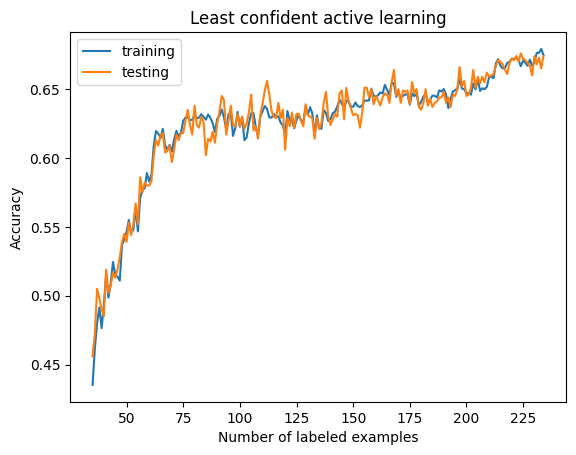

In [ ]:
plot(
    acc_train=least_confidence_train_acc,
    acc_test=least_confidence_test_acc,
    title="Least confident active learning"
)

## Margin Sampling: uses difference between top two predicted probabilities

In [ ]:
def margin_sampling(model, unlabeled_pool):
    # Get predicted probabilities for all classes
    probs = model.predict_proba(unlabeled_pool)

    # Sort probabilities for each sample
    sorted_probs = np.sort(probs, axis=1)

    # Compute the margin between the top two class probabilities
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]

    # Select the sample with the smallest margin (most uncertain)
    return np.argmin(margins)


In [ ]:
margin_sampling_train_acc, margin_sampling_test_acc = train(
    model=create_classifier(seed=42),
    n_iterations=200,
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx,
    score_fn=margin_sampling
)


Iteration: 10/200
Iteration: 20/200
Iteration: 30/200
Iteration: 40/200
Iteration: 50/200
Iteration: 60/200
Iteration: 70/200
Iteration: 80/200
Iteration: 90/200
Iteration: 100/200
Iteration: 110/200
Iteration: 120/200
Iteration: 130/200
Iteration: 140/200
Iteration: 150/200
Iteration: 160/200
Iteration: 170/200
Iteration: 180/200
Iteration: 190/200
Iteration: 200/200


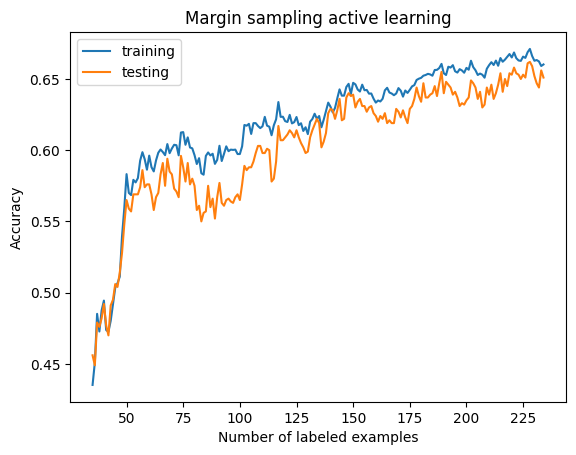

In [ ]:
plot(
    acc_train=margin_sampling_train_acc,
    acc_test=margin_sampling_test_acc,
    title="Margin sampling active learning"
)

## Entropy Sampling: uses information-theoretic entropy across all class probabilities

In [ ]:
def entropy_sampling(model, unlabeled_pool):
    # Get predicted probabilities for all classes
    probs = model.predict_proba(unlabeled_pool)

    # Compute entropy for each sample
    entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)

    # Select the sample with the highest entropy (most uncertain)
    return np.argmax(entropy)


In [ ]:
entropy_sampling_train_acc, entropy_sampling_test_acc = train(
    model=create_classifier(seed=42),
    n_iterations=200,
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx,
    score_fn=entropy_sampling
)


Iteration: 10/200
Iteration: 20/200
Iteration: 30/200
Iteration: 40/200
Iteration: 50/200
Iteration: 60/200
Iteration: 70/200
Iteration: 80/200
Iteration: 90/200
Iteration: 100/200
Iteration: 110/200
Iteration: 120/200
Iteration: 130/200
Iteration: 140/200
Iteration: 150/200
Iteration: 160/200
Iteration: 170/200
Iteration: 180/200
Iteration: 190/200
Iteration: 200/200


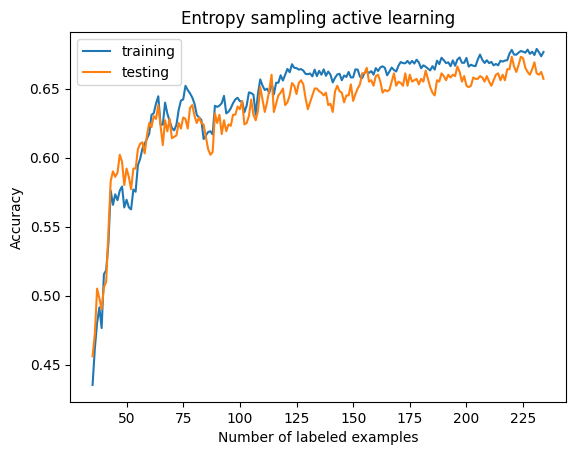

In [ ]:
plot(
    acc_train=entropy_sampling_train_acc,
    acc_test=entropy_sampling_test_acc,
    title="Entropy sampling active learning"
    )

## Query-by-Committee (QBC)

In [ ]:
def entropy_vote(labels, base=None):
    # Count unique labels and their frequencies
    value, counts = np.unique(labels, return_counts=True)

    # Normalize counts to get probabilities
    norm_counts = counts / counts.sum()

    # Set logarithm base; default is Euler's number (natural log)
    base = np.e if base is None else base

    # Compute and return entropy
    return -np.sum(norm_counts * np.log(norm_counts + 1e-10) / np.log(base))


In [ ]:
def query_by_committee(models, unlabeled_pool):
    # Get predictions from all models in the committee
    predictions = [model.predict(unlabeled_pool) for model in models]

    # Convert list of predictions to a 2D NumPy array (models x samples)
    predictions = np.array(predictions)

    # Compute disagreement among models using vote entropy
    disagreement = np.apply_along_axis(entropy_vote, axis=0, arr=predictions)

    # Select the sample with the highest disagreement
    return np.argmax(disagreement)


In [ ]:
classifiers = [create_classifier(),create_classifier(),create_classifier()]
main_model = create_classifier()

In [ ]:
def query_by_committee_train(models,
                             main_model,
                             n_iterations,
                             labeled_idx,
                             unlabeled_idx,
                             score_fn
                        ):
    # Dictionaries to store training and test accuracy over iterations
    acc_train_list = {}
    acc_test_list = {}

    for _ in range(n_iterations):
        # Train the main model on the current labeled dataset
        main_model.fit(X_train[labeled_idx], y_train[labeled_idx])

        # Create 3 bootstrapped samples from the labeled data
        samples = [resample(labeled_idx, replace=True) for _ in range(3)]
        models_fit = []

        # Train each model in the committee on its bootstrapped sample
        for sample, model in zip(samples, models):
            model = model.fit(X_train[sample], y_train[sample])
            models_fit.append(model)

        # Select the next sample using the committee's disagreement (score function)
        pool_index = score_fn(models_fit, X_train[unlabeled_idx])

        # Evaluate accuracy of the main model on full training and test sets
        acc_train = main_model.score(X_train, y_train)
        acc_test = main_model.score(X_test, y_test)

        # Store accuracy keyed by the current number of labeled samples
        acc_train_list[len(labeled_idx)] = acc_train
        acc_test_list[len(labeled_idx)] = acc_test

        # Update labeled and unlabeled pools
        labeled_idx = np.append(labeled_idx, pool_index)
        unlabeled_idx = np.delete(unlabeled_idx, pool_index)

    # Return dictionaries with recorded accuracies
    return acc_train_list, acc_test_list


In [ ]:
committee_acc_train, committee_acc_test = query_by_committee_train(
    models=classifiers,
    main_model=main_model,
    n_iterations=200,
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx,
    score_fn=query_by_committee
)


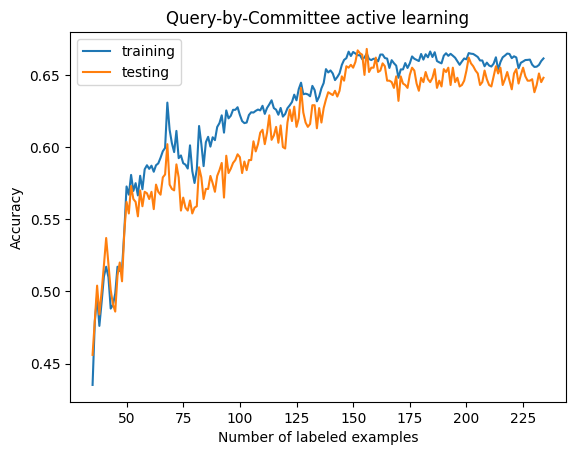

In [ ]:
plot(
    acc_train=committee_acc_train,
    acc_test=committee_acc_test,
    title="Query-by-Committee active learning"
    )

## Random Sampling (baseline)

In [ ]:
def random_query(n_iterations, labeled_idx, unlabeled_idx):
    # Randomly sample indices from the unlabeled pool
    random_unlabeled_sampled_idx = np.random.choice(unlabeled_idx, n_iterations, replace=False)

    # Dictionaries to store training and test accuracy
    acc_train = {}
    acc_test = {}

    for i, idx in enumerate(random_unlabeled_sampled_idx):
        # Train a new model on the current labeled set
        model = create_classifier(seed=42)
        model.fit(X_train[labeled_idx], y_train[labeled_idx])

        # Evaluate accuracy
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        # Store accuracy keyed by current number of labeled samples
        acc_train[len(labeled_idx)] = train_score
        acc_test[len(labeled_idx)] = test_score

        # Update labeled and unlabeled sets
        labeled_idx = np.append(labeled_idx, idx)
        unlabeled_idx = np.setdiff1d(unlabeled_idx, idx)

    return acc_train, acc_test



In [ ]:
random_query_acc_train, random_query_acc_test = random_query(
    n_iterations=200,
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx
)


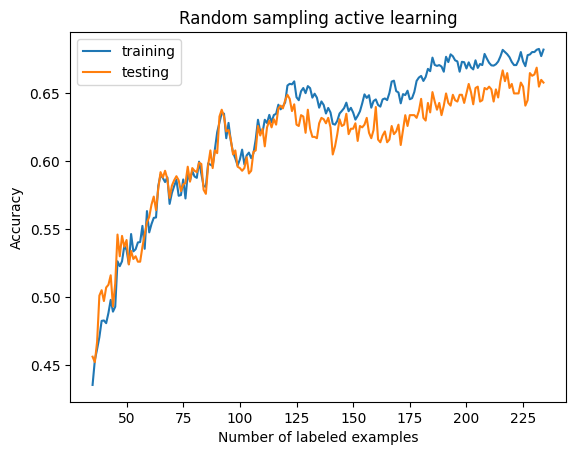

In [ ]:
plot(
    acc_train=random_query_acc_train,
    acc_test=random_query_acc_test,
    title="Random sampling active learning"
    )

Collect and plot learning curves (accuracy on the test set
vs. number of labeled examples). Discuss the observed behavior.
When/where does active learning provide the largest gains? At what point
do the gains diminish?

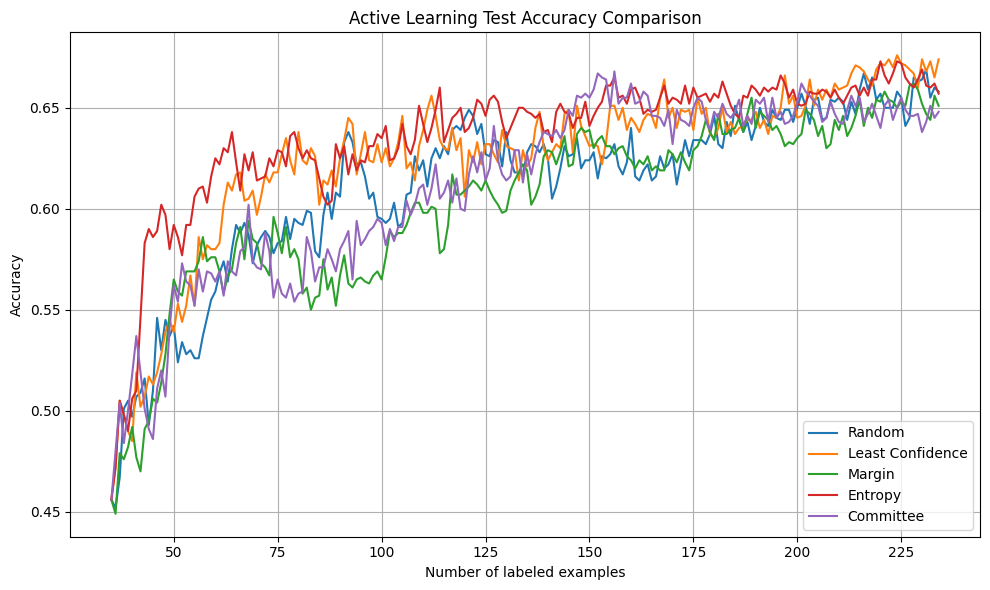

In [ ]:
plt.figure(figsize=(10, 6))

# Plot test accuracy for different active learning strategies
plt.plot(random_query_acc_test.keys(), random_query_acc_test.values(), label="Random")
plt.plot(least_confidence_test_acc.keys(), least_confidence_test_acc.values(), label="Least Confidence")
plt.plot(margin_sampling_test_acc.keys(), margin_sampling_test_acc.values(), label="Margin")
plt.plot(entropy_sampling_test_acc.keys(), entropy_sampling_test_acc.values(), label="Entropy")
plt.plot(committee_acc_test.keys(), committee_acc_test.values(), label="Committee")

# Labels and legend
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
plt.title("Active Learning Test Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


### Comments

For each query strategy, the accuracy of the model increases rapidely at the beginning of the training and start the learning rate start fading after the first 65 iterations. We then observe larger gain at the begining of the training, let say the first 65 iterations and start decreasing after the 65th iteration.